# Computational Elastostatics in 2 dimensions
### Brad Theilman

This notebook walks you through the basic definitions in continuum mechanics, which is the study of real materials - not just point particles. 
After explaining the definitions, we derive the basic differential equations describing mechanical equilibrium under the assumption of small deformation gradients. 
We then demonstrate numerical relaxation methods to compute the shape of a continuous body (thought of as Jello) in mechanical equilbrium, sagging under its own weight.  
Then, we discuss the deformation and compute the distribution of pressure and shear stress in the body.

This example was inspired by chapter 13 of Benny Lautrup's fantastic continuum mechanics textbook, "Physics of Continuous Matter"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Strain

We assume that the material particle original located at $(x, y)$ gets moved to the location $x' = x + u_x(x, y), y' = y + u_y(x, y)$.

So, we call $u_i(x, y)$ the deformation.  It is represented with two $N$ by $N$ matrices, giving the x deformation and y deformation.

We assume that the gradients of the deformation are small.  This is the standard assumption for linear elasticity.
Under this assumption, we can define the Cauchy strain tensor to be 

$$ u_{ij} = \nabla_i u_j + \nabla_j u_i $$

This tensor is symmetric, so there are 3 independent components in 2 dimensions. 

The next function computes the strains from the deformations

In [3]:
def strains(Ux, Uy, dx):
    Uxx = np.gradient(Ux, dx, axis=1, edge_order=2)
    Uyy = np.gradient(Uy, dx, axis=0, edge_order=2)
    Uxy = (1./2)*(np.gradient(Ux, dx, axis=0, edge_order=2) + np.gradient(Uy, dx, axis=1, edge_order=2))
    return (Uxx, Uyy, Uxy)

## Stress

Once we have the strains, we can use Hooke's law to compute the stresses.  Hooke's law posits a linear relationship between strains to stresses.
Furthermore, we assume the material is homogeneous and isotropic.  Homogeneous means that the linear relationship is the same everywhere in the material.
Isotropic means that there are no preferred directions. 

These assumptions restrict the form that the linear relationship can have.  There can be only two terms: one proportional to the strain tensor itself, and the other proportional to its trace. 
So we define 

$$ \sigma_{ij} = 2 \mu u_{ij} + \lambda \Sigma_k u_{kk} $$

The function below computes the stresses from the strain tensor

In [4]:
def stresses(Uxx, Uyy, Uxy, mu, lam):
    sxx = (2*mu +lam)*Uxx + lam*Uyy
    syy = (2*mu + lam)*Uyy + lam*Uxx
    sxy = 2*mu*Uxy
    syx = sxy
    return (sxx, syy, sxy, syx)

## Material Parameters
$ \mu $ and $ \lambda $ are called Lame parameters.  They are related to the more well-known material parameters called the Young's modulus and the Poisson ratio.  Here are two functions to compute the Lame parameters from Young's modulus and the Poisson ratio.

In [5]:
def lam(E, nu):
    return (E*nu) / ((1-2*nu)*(1+nu))

def mu(E, nu):
    return E / (2*(1+nu))

## Total Force Density

Consider a small material box located at $x, y$.  What is the total force due to stress in the $x$-direction? 
Let's sum up all of the forces on the sides of the box in the $x$ direction.

First, we have normal stresses on the faces normal to the x direction.  if the width of the box is $dx$, then the total force is

$$
F_x = \sigma_{xx}(x+dx, y) - \sigma_{xx}(x, y) \approx \partial_x \sigma_{xx} (x, y)
$$

But we could also have forces in the x direction acting on the surfaces normal to the y axis: these are the shear stresses.  So we have to add them:

$$
F_x = \partial_x \sigma_{xx} (x, y) + \sigma_{yx}(x, y+dx) - \sigma_{yx}(x, y) \approx \partial_x \sigma_{xx} (x, y) + \partial_y \sigma_{yx} (x, y)
$$

Thus, the total force on the material box due to stress is the divergence of the stress tensor:

$$
F_j = \nabla_i \sigma_{ij}
$$

What other forces act on the box?  Well, there could be body forces such as gravity that act on the whole particle itself, so we must include them:

$$
F_j = \nabla_i \sigma_{ij} + \rho g_j + f_j
$$

Where $g_i$ is the local gravitational acceleration vector, and $f_j$ represents any other forces present.

Let's define a function to compute the total force at each point in our material from the stresses, gravity, and whatever else we want:

In [6]:
def force(sxx, syy, sxy, syx, rho, g, dx, Fx=None, Fy=None):
    '''
    sxx : Normal stress in x direction
    syy : Normal stress in y direction
    syx : Shear stress
    rho : Material density
    g   : y component of downward gravitational acceleration
    Fx  : External x-directed body force
    Fy  : External y-directed body force
    
    '''
    if Fx is None:
        Fx = np.zeros_like(sxx)
    if Fy is None:
        Fy = np.zeros_like(syy)
    
    # Total force is divergence of stress tensor plus body forces
    fx = np.gradient(sxx, dx, axis=1, edge_order=2) + np.gradient(syx, dx, axis=0, edge_order=2) + Fx
    fy = np.gradient(sxy, dx, axis=1, edge_order=2) + np.gradient(syy, dx, axis=0, edge_order=2) - rho*g + Fy
    return (fx, fy)

### Equilibrium Equation

We now have enough available to define the problem we are trying to solve.  
We would like to know how an elastic body deforms when subject to various forces, such as its own weight. 
After deforming, the body will be at rest with no net accelerations. 
Newton's second law tells us that to have no net acceleration, all forces must some to zero. 

Since we are working with a continuum body, we want the accelerations of each material particle to be zero. 
This means that the total force density must equal zero. So, to summarize, we seek a vector function $u_i(x, y)$ that gives the deformation of the material particle located at $(x, y)$.  This deformation must be a solution to the system of partial differential equations

$$
\nabla_i \sigma_{ij} + F_j = 0
$$

$$ 
\sigma_{ij} = 2\mu u_{ij} + \lambda u_{ii}
$$

$$
u_{ij} = \nabla_i u_j + \nabla_j u_i
$$


### Boundary Conditions

Every partial differential equations needs boundary conditions. 
For simplicity, our domain is a square region in the x-y plane, so we have four boundaries. 
Since our partial differential equation is a second order differential equation for $u$, we need a condition on either the function itself or its derivative.  Since the stress depends linearly on the derivatives of the deformation, it will be more intuitive to impose boundary conditions on the stress rather than the derivative of the deformation itself.

If a particular component of the stress vector at a boundary vanishes, that means there is no contact force acting on that boundary. Thus, that boundary is "free" in the sense that it can move wherever it needs.

If a deformation component vanishes at the boundary, then that boundary is "fixed" and cannot move.  The surface to which it is attached will provide whatever stres is necessary at that boundary to maintain equilibrium. 

Here is a function to force the boundaries of our approximate solution to adhere to the appropriate boundary conditions.

You can set these however you want, but for our example, the material will be sitting on a floor that it can slide along but not pass through.  It will be also be stuck against a wall that it can't separate from, but it can slide up and down along. 

In [7]:
def set_boundary(sxx, syy, sxy, syx, Ux, Uy):
    # For a free boundary, the stress (s) has to be zero
    # For a constrained boundary, the deformation must be zero, but the stress can be whatever it needs to be to maintain zero deformation.  
    
    # Boundary at x = 0 (Left sized)
    Ux[:, 0] = 0     # Fixed - no movement in the x direction
    syx[:, 0] = 0    # No shear stress in y direction - surface may slide along x = 0 plane
    #sxx[:, 0] = 0   # No normal stress in x direction - surface is free. 
    #Uy[:, 0] = 0    # No deformation in y direction - surface cannot slide along x = 0 plane. 

    
    # Boundary at y = 0 (Bottom)
    Uy[0, :] = 0     # Fixed in y direction; Body may not fall through the floor
    sxy[0, :] = 0    # Free surface; Body may slide along the floor
    #syy[0, :] = 0   # Free surface; Body may fall through the floor
    #Ux[0, :] = 0    # Fixed in x direction; Body may not slide along floor
    
    # Boundary at x = 1 (Right side)
    sxx[:, -1] = 0   # Free surface
    syx[:, -1] = 0   # Free surface 
    #Ux[:, -1] = 0   # Fixed in x direction
    #Uy[:, -1] = 0   # Fixed in y direction
    
    # y = b
    syy[-1, :] = 0
    sxy[-1, :] = 0
    
    return (sxx, syy, sxy, syx, Ux, Uy)
    
    

### Setting up domain and parameters

Here we initialize our domain and our material parameters.  The domain is a square, N x N grid, spanning the coordinate range \[0, 1\]

We set the Young's modulus and Poisson's ratio and then compute the equivalent Lame parameters

Then we set the material density and gravitational acceleration

In [78]:
## Set up grid
N = 21     # N x N grid
Ux = np.zeros((N, N))
Uy = np.zeros((N, N))
dx = 1./(N-1)  # Meters
xcoord = np.linspace(0, 1, N)
ycoord = np.linspace(0, 1, N)

E = 20      # Pascal
nu = 1./3  # (dimensionless)

# Compute Lame parameters
m = mu(E, nu)
l = lam(E, nu)

# Density and gravity
rho = 1   # kg/m^3
g = 9.81     # m/s^2

### Compute the deformation

For each iteration, we compute the total force density vector at each material particle. 

Since, generally, force is the spatial gradient of energy, we can lower the energy of the material by deforming along the force vector.  

If we do this long enough, and provide all of our approximate expressions are numerically stable, the deformations will "relax" into their equilibrium conditions, where there is no net force, and elastic potential energy is minimized.

In [79]:
eps = (0.9/E)*(dx**4 / (2*dx**2))
ITS = 2500
forces = np.zeros(ITS)

# Gradient Descent
for it in range(ITS):
    
    # Compute strain tensor field from deformation vector field
    (Uxx, Uyy, Uxy) = strains(Ux, Uy, dx)
    
    # Use homogeneous, isotropic Hooke's law to compute stress tensor field
    (sxx, syy, sxy, syx) = stresses(Uxx, Uyy, Uxy, m, l)
    
    # Enforce boundary conditions
    (sxx, syy, sxy, syx, Ux, Uy) = set_boundary(sxx, syy, sxy, syx, Ux, Uy)
    
    # Compute total force density from body forces and stress gradients
    (fx, fy) = force(sxx, syy, sxy, syx, rho, g, dx)
    
    # Compute gradient descent step
    # Elastic potential energy gradient is proportional to totaal force density
    dUx = eps*fx
    dUy = eps*fy
    
    # Update deformation field
    Ux += dUx
    Uy += dUy
    
    # Save current total force magnitude
    forces[it] = np.sum(dx*dx*np.sqrt(fx**2 + fy**2))
    
    # Re-enforce boundary conditions
    (sxx, syy, sxy, syx, Ux, Uy) = set_boundary(sxx, syy, sxy, syx, Ux, Uy)

### Monitor the relaxation

Here we plot the total force magnitude integrate over the whole material. We expect that if total force tends to zero, we have reached equillibrium.

Text(0.5,1,'Relaxation')

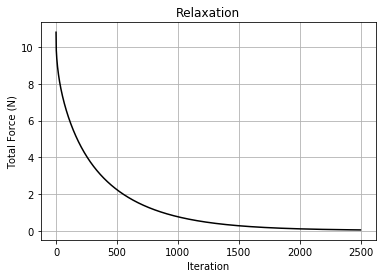

In [80]:
plt.figure()
plt.plot(forces, 'k')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Total Force (N)')
plt.title('Relaxation')

### Visualize the deformation vector field

The deformation is represented by a field of 2D vectors at each point in the material.  

Let's create a quiver plot to illustrate which direction each material particle moves under its own weight

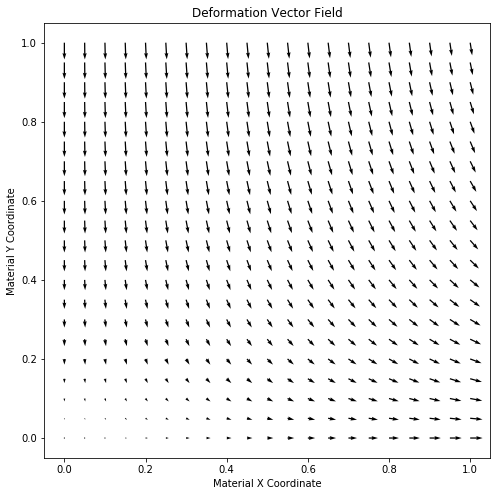

In [81]:
plt.figure(figsize=(8, 8))
plt.quiver(xcoord, ycoord, Ux, Uy)
plt.title('Deformation Vector Field')
plt.xlabel('Material X Coordinate')
plt.ylabel('Material Y Coordinate');

We see that along the x = 0 boundary, the deformation vector is purely vertical.  This agrees with our boundary conditions that stated that the material can slide up and down along the boundary but can't separate from the wall.  Similarly, the y = 0 boundary shows purely horizontal deformation.  Elsewhere in the material, the material particles show a downward component of sagging due to gravity as well as a horizontal component indicating the material bulges outwards under its own weight. 

### Visualizing the deformed material

We can get a pretty quick visualization of the deformed material by simply adding the deformation vectors to a grid of particles located at the original material particle coordinates (themselves arranged as a grid).  Then, we plot these new points as a scatter plot.

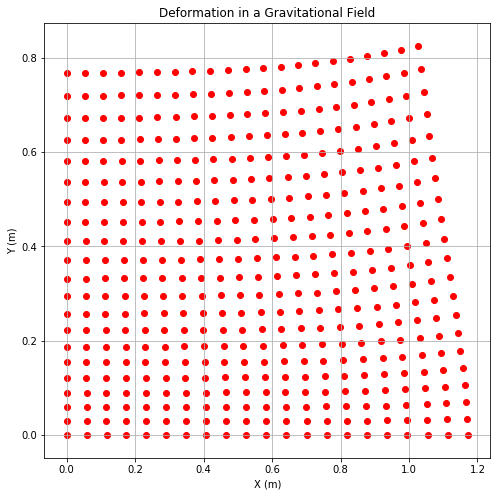

In [87]:
X, Y = np.meshgrid(xcoord, ycoord)

plt.figure(figsize=(8, 8))
#plt.scatter(X, Y, c='black')
plt.scatter(X + Ux, Y+Uy, c='red')
plt.grid()
plt.title('Deformation in a Gravitational Field')
plt.xlabel('X (m)')
plt.ylabel('Y (m)');

You can clearly see the sagging and bulging due to gravity, and the results fit our intution.

Let's define a few functions to compute and plot the outline of the deformed material.  This will make a more pleasing and intuitive plot

In [85]:
def get_outline(X, Y):
    
    a = np.hstack((X[0, :][:, np.newaxis], Y[0, :][:, np.newaxis]))
    b = np.hstack((X[-1, :][:, np.newaxis], Y[-1, :][:, np.newaxis]))
    c = np.hstack((X[:, 0][:, np.newaxis], Y[:, 0][:, np.newaxis]))
    d = np.hstack((X[:, -1][:, np.newaxis], Y[:, -1][:, np.newaxis]))
    return (a,b,c,d)

def plot_outline(a, b, c, d, *args, **kwargs):
    plt.plot(a[:, 0], a[:, 1], *args, **kwargs)
    plt.plot(b[:, 0], b[:, 1], *args, **kwargs)
    plt.plot(c[:, 0], c[:, 1], *args, **kwargs)
    plt.plot(d[:, 0], d[:, 1], *args, **kwargs)

### Deformed vs. Undeformed comparison

Here we visualize the outlines of the deformed and undeformed materials on the same plot.  We can see that with such a low Young's modulus, the material is weak and can't hold itself up very well under its own weight.  This leads to a relatively drastic deformation.  However, because the deformation *gradient* is small, our approximation methods can be trusted.

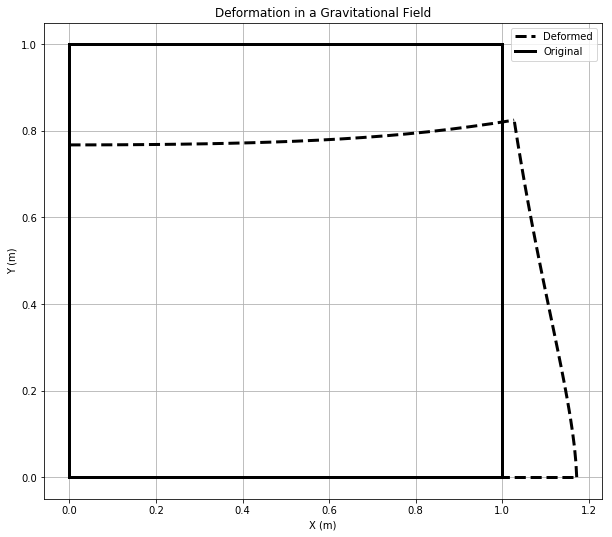

In [86]:
plt.figure(figsize=(10, 10))
deformed = get_outline(X+Ux, Y+Uy)
original = get_outline(X, Y)

plot_outline(*deformed, 'k--', linewidth=3, label='Deformed')
plot_outline(*original, 'k-', linewidth=3, label='Original')
plt.gca().set_aspect('equal')
plt.legend(loc='best')

plt.grid(which='both')
plt.title('Deformation in a Gravitational Field')
plt.xlabel('X (m)')
plt.ylabel('Y (m)');

### Pressure and Shear Stresses

The deformation is going to induce pressure and shear stresses inside the material that act to counter the gravitational force or enforce the boundary conditions by resulting from the surfaces forces the boundary walls exert on the material.  Let's visualize the distribution of pressure and shear stress.

The pressure is defined as the negative of the trace of the stress tensor.  The reason for the minus sign is that positive normal stress indicates a pulling along the normal direction, and we think of positive pressure as a "pushing" or "compressing" force.  This is just a convention, and the results are equivalent no matter which sign you use, as long as you are consistent!

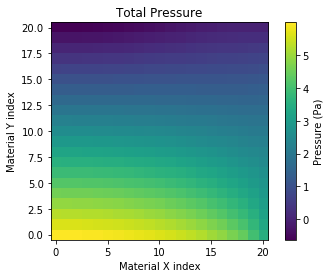

In [82]:
plt.imshow(-(sxx + syy)/2, origin='lower', aspect='equal')
plt.colorbar(label='Pressure (Pa)')
#plt.contour(-(sxx+syy)/2, colors='black')
plt.title('Total Pressure');
plt.xlabel('Material X index')
plt.ylabel('Material Y index');


We see the regions of highest pressure are at the bottom of the material, which makes sense because this part of the material has to support the weight of all the material above it.
We also see that the pressure is higher near the fixed boundaries, which also makes sense because the material is able to expand at the free boundaries, lowering the pressure. 

Now we plot the shear stresses

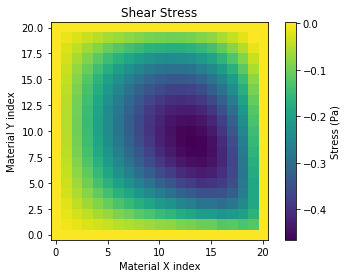

In [83]:
plt.imshow(sxy, origin='lower', aspect='equal')
plt.colorbar(label='Stress (Pa)')
#plt.contour(sxy, colors='black')
plt.title('Shear Stress')
plt.xlabel('Material X index')
plt.ylabel('Material Y index');



Since we are working in two dimensions, there is only one component of shear stress.  We see that the shear stress is zero along the boundaries, as it should be, since there is no friction or "sticking" along the boundaries.  However, the shear stress shows its greatest magnitude towards the middle, where the combination of compressing vertically due to gravity and the bulging outward are the greatest.  

## Conclusion

In this notebook we have defined the notions of stress and strain for a continuous material body under the assumption of small deformation gradients.  We applied Newton's laws to derive partial differential equations describing the relationships between stress, strain, deformation, and mechanical equilibrium.  We applied a relaxation technique to solve for the equilibrium deformation of a continuous body deforming under its own weight, subject to non trivial boundary conditions.  We visualized the resulting deformation, and found that it matched our intuition. We used our results to compute the pressure and shear stress distribution inside the material, providing insight into the mechanics of continuous bodies.

### Where to go from here

I hope you try to play around with the parameters and boundary conditions.  You will be able to identify when the assumptions of the model break down, but also you could simulate more interesting scenarios than we have here. For example, what if the mateiral was dangling from a ceiling? Or what if the material was a bar stretched between two anchors, like a bridge?  Figure out what the boundary conditions would be in these cases, and make guesses as to what the deformations and stresses should look like. Do they match your intution?

Again, this example was taken from chapter 13 of Benny Lautrup's "Physics of Continuous Matter", which I can't recommend enough.  If you can get a copy, there are plenty of analytic examples that will help you understand continuum and fluid mechanics in a multiude of situations that come up in every day life. 

## Thanks for reading!